# DATA

In [1]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import re


# Load dataset



In [3]:

# Đường dẫn tới các file
TRAIN_PATH ='/kaggle/input/uit-visd4sa-processed/train.csv'
VAL_PATH ='/kaggle/input/uit-visd4sa-processed/val.csv'
TEST_PATH ='/kaggle/input/uit-visd4sa-processed/test.csv'

# Đọc các file CSV
train_df = pd.read_csv(TRAIN_PATH)
val_df = pd.read_csv(VAL_PATH)
test_df = pd.read_csv(TEST_PATH)

# Lấy tất cả các tên cột từ cả ba DataFrame
all_columns = set(train_df.columns).union(set(val_df.columns)).union(set(test_df.columns))

all_columns

{'BATTERY',
 'CAMERA',
 'DESIGN',
 'FEATURES',
 'GENERAL',
 'PERFORMANCE',
 'PRICE',
 'SCREEN',
 'SER&ACC',
 'STORAGE',
 'Sentence'}

# Preprocess data

In [4]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 70.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.0 MB/s eta 0:00:00


In [5]:
import regex as re
import string
import emoji

from nltk import flatten
import unicodedata
from underthesea import word_tokenize


In [6]:
# 1. Loại bỏ các thẻ HTML
def remove_HTML(text):
    clean = re.compile('<.*?>')
    return re.sub(clean,'', text)

# 2. Chuyển đổi các ký tự Unicode về dạng chuẩn
def convert_unicode(text):
    return unicodedata.normalize('NFC', text)

# 3. Loại bỏ các ký tự kéo dài
def remove_elongated_chars(text):
    replacements = {
       'a':'àáảãạăằắẳẵặâầấẩẫậ',
       'e':'èéẻẽẹêềếểễệ',
       'i':'ìíỉĩị',
       'o':'òóỏõọôồốổỗộơờớởỡợ',
       'u':'ùúủũụưừứửữự',
       'y':'ỳýỷỹỵ',
       'd':'đ',
       'A':'ÀÁẢÃẠĂẰẮẲẴẶÂẦẤẨẪẬ',
       'E':'ÈÉẺẼẸÊỀẾỂỄỆ',
       'I':'ÌÍỈĨỊ',
       'O':'ÒÓỎÕỌÔỒỐỔỖỘƠỜỚỞỠỢ',
       'U':'ÙÚỦŨỤƯỪỨỬỮỰ',
       'Y':'ỲÝỶỸỴ',
       'D':'Đ'
    }
    
    for char, replacements_str in replacements.items():
        pattern = rf"({char})\1+"
        text = re.sub(pattern, char, text)
    
    pattern = r"(\w)\1+"
    text = re.sub(pattern, r'\1', text)
    return text

# 4. Xử lý các từ phủ định
def handle_negation(text):
    not_words = {"không",'không hề', "chẳng", "chưa", "không phải", "chả", "mất",
                 "thiếu", "đếch", "đéo", "kém", "nỏ", "not",
                 "bớt", "không bao giờ", "chưa bao giờ"}
    not_words = sorted(not_words, key=len, reverse=True)
    pattern = r'\b(?:'+'|'.join(re.escape(word) for word in not_words) + r')\b'
    text = re.sub(pattern,'không', text, flags=re.IGNORECASE)
    return text

# 5. Chuẩn hóa các từ viết tắt thường gặp
def normalize_acronyms(text):
    acronyms = {
       'ô kêi':'ok','okie':'ok','o kê':'ok',
       'okey':'ok','ôkê':'ok','oki':'ok','oke': 'ok','okay':'ok','okê':'ok',
       'tks': u'cám ơn','thks': u'cám ơn','thanks': u'cám ơn','ths': u'cám ơn','thank': u'cám ơn',
       '⭐':'star','*':'star','🌟':'star',
       'kg': u'không','not': u'không', u'kg': u'không','"k': u'không','kh':u'không','kô':u'không','hok':u'không','kp': u'không phải',u'kô': u'không','"ko': u'không', u'ko': u'không', u'k': u'không','khong': u'không', u'hok': u'không',
       'cute': u'dễ thương','vs': u'với','wa':'quá','wá': u'quá','j': u'gì','“':'',
       'sz': u'cỡ','size': u'cỡ', u'đx': u'được','dk': u'được','dc': u'được','đk': u'được',
       'đc': u'được','authentic': u'chuẩn chính hãng',u'aut': u'chuẩn chính hãng', u'auth': u'chuẩn chính hãng','store': u'cửa hàng',
       'shop': u'cửa hàng','sp': u'sản phẩm','gud': u'tốt','god': u'tốt','wel done':'tốt','good': u'tốt','gút': u'tốt',
       'sấu': u'xấu','gut': u'tốt', u'tot': u'tốt', u'nice': u'tốt','perfect':'rất tốt','bt': u'bình thường',
       'time': u'thời gian','qá': u'quá', u'ship': u'giao hàng', u'm': u'mình', u'mik': u'mình',
       'ể':'ể','product':'sản phẩm','quality':'chất lượng','chat':'chất','excelent':'hoàn hảo','bad':'tệ','fresh':'tươi','sad':'tệ',
       'date': u'hạn sử dụng','hsd': u'hạn sử dụng','quickly': u'nhanh','quick': u'nhanh','fast': u'nhanh','delivery': u'giao hàng',u'síp': u'giao hàng',
       'beautiful': u'đẹp tuyệt vời', u'tl': u'trả lời', u'r': u'rồi', u'shopE': u'cửa hàng',u'order': u'đặt hàng',
       'chất lg': u'chất lượng',u'sd': u'sử dụng',u'dt': u'điện thoại',u'nt': u'nhắn tin',u'tl': u'trả lời',u'sài': u'xài',u'bjo':u'bao giờ',
       'thick': u'thích','thik': u'thích', u'sop': u'cửa hàng', u'shop': u'cửa hàng', 
       'fb':'facebook','face':'facebook','very': u'rất',u'quả ng':u'quảng ',
       'dep': u'đẹp',u'xau': u'xấu','delicious': u'ngon', u'hàg': u'hàng', u'qủa': u'quả',
       'iu': u'yêu','fake': u'giả mạo','trl':'trả lời',
       'por': u'tệ','poor': u'tệ','ib':u'nhắn tin','rep':u'trả lời',u'fback':'feedback','fedback':'feedback',
       'max': u'cực kỳ',
       'full':'đầy đủ', 'ful':'đầy đủ'
    }
    words = text.split()
    normalized_text =' '.join([acronyms.get(word.lower(), word) for word in words])
    return normalized_text

# 6. Phân đoạn từ cho tiếng Việt
def word_segmentation(text):
    return word_tokenize(text, format="text")

def process_emojis(text):
    emojis_list = {
        "👹": "negative", "👻": "positive", "💃": "positive",'🤙': 'positive ', '👍': 'positive ',
        "💄": "positive", "💎": "positive", "💩": "positive","😕": "negative", "😱": "negative", "😸": "positive",
        "😾": "negative", "🚫": "negative",  "🤬": "negative","🧚": "positive", "🧡": "positive",'🐶':'positive ',
        '👎': 'negative ', '😣': 'negative ','✨': 'positive ', '❣': 'positive ','☀': 'positive ',
        '♥': 'positive ', '🤩': 'positive ', 'like': 'positive ', ':))': 'positive ', ':)': 'positive ',
        'he he': 'positive ','hehe': 'positive ','hihi': 'positive ', 'haha': 'positive ', 'hjhj': 'positive ',
        ' lol ': 'negative ',' cc ': 'negative ', 'huhu': 'negative ', '><': u'positive ',
        '💌': 'positive ', '🥰': 'positive ', '🙆' : 'positive ', '😅' : 'negative ',
        '🤒' : 'negative ', '🤨' : 'negative ', '🤦' : 'negative ', '😬' :'negative ',
        '🔋' : 'positive ', '💔' : 'negative ', '🤮' : 'negative ', '✋' : 'positive ',
        '🤣': 'positive ', '🖤': 'positive ', '🤤': 'positive ', ':(': 'negative ', '😢': 'negative ',
        '❤': 'positive ', '😍': 'positive ', '😘': 'positive ', '😪': 'negative ', '😊': 'positive ',
        '?': ' ? ', '😁': 'positive ', '💖': 'positive ', '😟': 'negative ', '😭': 'negative ',
        '💯': 'positive ', '💗': 'positive ', '♡': 'positive ', '💜': 'positive ', '🤗': 'positive ',
        '^^': 'positive ', '😨': 'negative ', '☺': 'positive ', '💋': 'positive ', '👌': 'positive ',
        '😖': 'negative ', '😀': 'positive ', ':((': 'negative ', '😡': 'negative ', '😠': 'negative ',
        '😒': 'negative ', '🙂': 'positive ', '😏': 'negative ', '😝': 'positive ', '😄': 'positive ',
        '😙': 'positive ', '😤': 'negative ', '😎': 'positive ', '😆': 'positive ', '💚': 'positive ',
        '✌': 'positive ', '💕': 'positive ', '😞': 'negative ', '😓': 'negative ', '️🆗️': 'positive ',
        '😉': 'positive ', '😂': 'positive ', ':v': 'positive ', '=))': 'positive ', '😋': 'positive ',
        '💓': 'positive ', '😐': 'negative ', ':3': 'positive ', '😫': 'negative ', '😥': 'negative ',
        '😃': 'positive ', '😬': ' 😬 ', '😌': ' 😌 ', '💛': 'positive ', '🤝': 'positive ', '🎈': 'positive ',
        '😗': 'positive ', '🤔': 'negative ', '😑': 'negative ', '🔥': 'negative ', '🙏': 'negative ',
        '🆗': 'positive ', '😻': 'positive ', '💙': 'positive ', '💟': 'positive ',
        '😚': 'positive ', '❌': 'negative ', '👏': 'positive ', ';)': 'positive ', '<3': 'positive ',
        '🌝': 'positive ',  '🌷': 'positive ', '🌸': 'positive ', '🌺': 'positive ',
        '🌼': 'positive ', '🍓': 'positive ', '🐅': 'positive ', '🐾': 'positive ', '👉': 'positive ',
        '💐': 'positive ', '💞': 'positive ', '💥': 'positive ', '💪': 'positive ',
        '💰': 'positive ',  '😇': 'positive ', '😛': 'positive ', '😜': 'positive ',
        '🙃': 'negative ', '🤑': 'positive ', '🤪': 'positive ','☹': 'negative ',  '💀': 'negative ',
        '😔': 'negative ', '😧': 'negative ', '😩': 'negative ', '😰': 'negative ', '😳': 'negative ',
        '😵': 'negative ', '😶': 'negative ', '🙁': 'negative ', '🎉': 'positive '}
    for emoji, label in emojis_list.items():
        text = text.replace(emoji, f'EMO{label.lower()}' )
        
    text = ' ' .join(text.split())
    return text

# 7. Loại bỏ các ký tự không cần thiết khỏi văn bản
def remove_unnecessary_characters(text):
    text = re.sub(r'\s+', ' ', text)  # Loại bỏ khoảng trắng thừa
    text = re.sub(r'[^\w\s]', '', text)  # Loại bỏ các ký tự đặc biệt
    return text.strip()

# 8. Kết hợp các hàm để tiền xử lý văn bản
def text_preprocess(text):
    text = remove_HTML(text)
    text = normalize_acronyms(text)
    text = convert_unicode(text)
    text = remove_elongated_chars(text)
    text = handle_negation(text)
    text = process_emojis(text)
    #text = word_segmentation(text)
    text = remove_unnecessary_characters(text)
    return text

In [7]:
!pip install tf-models-official


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.0/58.0 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 68.4 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 88.5 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 62.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.2/426.2 kB 25.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 61.6 MB/s

In [8]:
import pandas as pd
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from official.nlp import optimization


In [9]:
# Define pre-trained model and tokenizer
PRETRAINED_MODEL = 'vinai/phobert-base'  # Choose your preferred Vietnamese BERT model
tokenizer = AutoTokenizer.from_pretrained(PRETRAINED_MODEL)
tokenizer.max_model_input_sizes

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

{'vinai/phobert-base': 256, 'vinai/phobert-large': 256}

In [10]:
# Prepare data for TensorFlow
MAX_SEQUENCE_LENGTH = tokenizer.model_max_length
BATCH_SIZE = 16


In [11]:
import numpy as np

In [12]:
def make_outputs(df):
    outputs = []
    for row in range(len(df)):
        row_one_hot = []
        for col in range(1, len(df.columns)):
            sentiment = df.iloc[row, col]
            if sentiment == 1: one_hot = [1, 0, 0, 0] #Pos
            elif sentiment == 2: one_hot = [0, 1, 0, 0] # Neg
            elif sentiment == 3: one_hot = [0, 0, 1, 0] # Neu
            elif sentiment == 0: one_hot = [0, 0, 0, 1] # None
            row_one_hot.append(one_hot)
        outputs.append(row_one_hot)
    return np.array(outputs, dtype='uint8')
y_train = make_outputs(train_df)
y_val = make_outputs(val_df)
y_test = make_outputs(test_df)

print('Train outputs:', y_train.shape)
print('Validate outputs:', y_val.shape)
print('Test outputs:', y_test.shape)
y_train[0]

Train outputs: (7625, 10, 4)
Validate outputs: (1086, 10, 4)
Test outputs: (2186, 10, 4)


array([[1, 0, 0, 0],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0],
       [0, 0, 0, 1]], dtype=uint8)

In [13]:
from datasets import load_dataset
raw_datasets = load_dataset('csv', data_files={'train': TRAIN_PATH, 'val': VAL_PATH, 'test': TEST_PATH})
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

Generating val split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'BATTERY', 'CAMERA', 'DESIGN', 'FEATURES', 'GENERAL', 'PERFORMANCE', 'PRICE', 'SCREEN', 'SER&ACC', 'STORAGE'],
        num_rows: 7625
    })
    val: Dataset({
        features: ['Sentence', 'BATTERY', 'CAMERA', 'DESIGN', 'FEATURES', 'GENERAL', 'PERFORMANCE', 'PRICE', 'SCREEN', 'SER&ACC', 'STORAGE'],
        num_rows: 1086
    })
    test: Dataset({
        features: ['Sentence', 'BATTERY', 'CAMERA', 'DESIGN', 'FEATURES', 'GENERAL', 'PERFORMANCE', 'PRICE', 'SCREEN', 'SER&ACC', 'STORAGE'],
        num_rows: 2186
    })
})

In [14]:
print('input_ids of sentence 1484:', raw_datasets['train'][1484])

input_ids of sentence 1484: {'Sentence': 'Đã mua tại thế giới di động thị xã An Khê gia Lai...qua 48h sử dụng cảm nhận máy rất đẹp mượt mà hợp cho mình làm vlog camera chụp hình quay video rất đẹp.. nhân viên rất nhiệt tình và dễ thương...pin rất trâu nha mọi người...sau này sẽ bình luận tiếp nha.. quá đẹp và sang trọng..', 'BATTERY': 1, 'CAMERA': 1, 'DESIGN': 1, 'FEATURES': 0, 'GENERAL': 0, 'PERFORMANCE': 1, 'PRICE': 0, 'SCREEN': 0, 'SER&ACC': 1, 'STORAGE': 0}


In [15]:
def tokenize_function(dataset):
    clean_texts = list(map(text_preprocess, dataset['Sentence']))
    return tokenizer(clean_texts, max_length=tokenizer.model_max_length, padding='max_length', truncation=True)

In [16]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
print('input_ids of sentence 1484:', tokenized_datasets['train'][1484]['input_ids'])

Map:   0%|          | 0/7625 [00:00<?, ? examples/s]

Map:   0%|          | 0/1086 [00:00<?, ? examples/s]

Map:   0%|          | 0/2186 [00:00<?, ? examples/s]

input_ids of sentence 1484: [0, 2003, 188, 35, 570, 681, 4453, 2697, 5298, 176, 2234, 7536, 3931, 1042, 6010, 89, 10421, 1664, 5717, 8410, 4263, 154, 558, 59, 258, 11537, 64, 2288, 13, 68, 47, 1659, 30669, 1901, 690, 819, 588, 1134, 59, 258, 1362, 1430, 59, 2515, 939, 6, 592, 56873, 1701, 2179, 59, 2959, 7045, 207, 31485, 1384, 53, 23, 38, 2404, 6928, 917, 7045, 204, 258, 6, 295, 7594, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [17]:
print('Decode:', tokenizer.decode(tokenized_datasets['train'][1484]['input_ids']))


Decode: <s> Đã mua tại thế giới di động thị xã An Khê gia Laiqua 48h sử dụng cảm nhận máy rất đẹp mượt mà hợp cho mình làm vlog camera chụp hình quay video rất đẹp nhân viên rất nhiệt tình và dễ thươngpin rất trâu nha mọi ngườisau này sẽ bình luận tiếp nha quá đẹp và sang trọng </s> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <p

In [18]:
tokenized_datasets['train']

Dataset({
    features: ['Sentence', 'BATTERY', 'CAMERA', 'DESIGN', 'FEATURES', 'GENERAL', 'PERFORMANCE', 'PRICE', 'SCREEN', 'SER&ACC', 'STORAGE', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 7625
})

In [19]:
train_dataset = tokenized_datasets["train"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=True
)

validation_dataset = tokenized_datasets["val"].to_tf_dataset(
    columns=["input_ids", "token_type_ids", "attention_mask"], batch_size=BATCH_SIZE, shuffle=True
)

In [38]:
train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 40), dtype=tf.uint8, name=None))>

In [20]:
import tensorflow as tf
from transformers import TFAutoModel, AutoTokenizer
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate, GlobalAveragePooling1D


In [21]:
topic = train_df.columns[1:]

In [55]:
class BertLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(BertLayer, self).__init__(**kwargs)
        self.bert = TFAutoModel.from_pretrained(PRETRAINED_MODEL)

    def call(self, inputs):
        input_ids, attention_mask, token_type_ids = inputs
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        return outputs.last_hidden_state  

def create_model(optimizer):
    # Build your model on top of BERT
    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='attention_mask')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='token_type_ids')

    bert_layer = BertLayer()([input_ids, attention_mask, token_type_ids])
    # LSTM layer on top of BERT output
    lstm_output = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True))(bert_layer)
    lstm_output = tf.keras.layers.GlobalAveragePooling1D()(lstm_output)
    
    dense = concatenate([
        Dense(
            units = 4, 
            activation = 'softmax',
            name = label.replace('&', '_'),
        )(lstm_output) for label in topic
    ], axis = -1)
    # Define your model
    model = Model(inputs=[input_ids, attention_mask, token_type_ids], outputs=dense)
    
    
    # Compile your model
    #model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    
    model.summary()
    return model

In [56]:
"""from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=1e-5)
type(optimizer)"""

'from tensorflow.keras.optimizers import Adam\noptimizer = Adam(learning_rate=1e-5)\ntype(optimizer)'

In [57]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay

EPOCHS = 100
# Số bước huấn luyện là số lượng mẫu trong tập dữ liệu, chia cho kích thước lô sau đó nhân
# với tổng số epoch. Lưu ý rằng tf_train_dataset ở đây là tf.data.Dataset theo lô,
# không phải là Hugging Face Dataset, vì vậy len() của nó đã là num_samples // batch_size.
num_train_steps = len(train_dataset) * EPOCHS
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

In [58]:
num_train_steps

47700

In [59]:
from tensorflow.keras.optimizers import Adam

opt = Adam(learning_rate=lr_scheduler)

In [60]:
model = create_model(opt)

Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_type_ids      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_2        │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
│                     │                   │            │ token_type_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 256, 128)  │    426,496 │ bert_layer_2[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_2[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BATTERY (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CAMERA (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DESIGN (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FEATURES (Dense)    │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GENERAL (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PERFORMANCE (Dense) │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRICE (Dense)       │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SCREEN (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SER_ACC (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STORAGE (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 40)        │          0 │ BATTERY[0][0],    │
│ (Concatenate)       │                   │            │ CAMERA[0][0],     │
│                     │                   │            │ DESIGN[0][0],     │
│                     │                   │            │ FEATURES[0][0],   │
│                     │                   │            │ GENERAL[0][0],    │
│                     │                   │            │ PERFORMANCE[0][0… │
│                     │                   │            │ PRICE[0][0],      │
│                     │                   │            │ SCREEN[0][0],     │
│                     │                   │            │ SER_ACC[0][0],    │
│                     │                   │            │ STORAGE[0][0]   

 Total params: 431,656 (1.65 MB)

 Trainable params: 431,656 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
# Create TensorFlow Datasets
def encode_data(tokenized_datasets, labels):
    return (
        {
            'input_ids': tf.constant(tokenized_datasets['input_ids']),
            'attention_mask': tf.constant(tokenized_datasets['attention_mask']),
            'token_type_ids': tf.constant(tokenized_datasets['token_type_ids'])
        },
        tf.constant(labels)
    )

In [62]:
train_data = encode_data(tokenized_datasets['train'], np.reshape(y_train, (-1, 40)))
val_data = encode_data(tokenized_datasets['val'], np.reshape(y_val, (-1, 40)))


In [63]:
train_data

({'input_ids': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[    0, 18297,  8480, ...,     1,     1,     1],
         [    0,  6454,  2302, ...,     1,     1,     1],
         [    0, 25438,    94, ...,     1,     1,     1],
         ...,
         [    0,  4983,  1449, ...,     1,     1,     1],
         [    0,    53,   124, ...,     1,     1,     1],
         [    0,  4983,   537, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

In [64]:
# Create TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices(val_data).batch(BATCH_SIZE)

In [65]:
train_data

({'input_ids': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[    0, 18297,  8480, ...,     1,     1,     1],
         [    0,  6454,  2302, ...,     1,     1,     1],
         [    0, 25438,    94, ...,     1,     1,     1],
         ...,
         [    0,  4983,  1449, ...,     1,     1,     1],
         [    0,    53,   124, ...,     1,     1,     1],
         [    0,  4983,   537, ...,     1,     1,     1]], dtype=int32)>,
  'attention_mask': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         ...,
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0],
         [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>,
  'token_type_ids': <tf.Tensor: shape=(7625, 256), dtype=int32, numpy=
  array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 

In [66]:
!pip install --upgrade wandb tensorflow


In [67]:
import os
import wandb
import tensorflow as tf
import numpy as np
import warnings
import logging
# Set TensorFlow logging level to ERROR to suppress warnings and informational messages
tf.get_logger().setLevel('ERROR')
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Additional method to suppress specific warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'  # Suppress TensorFlow warnings and errors: 0 = all logs, 1 = filter out INFO, 2 = filter out WARNING, 3 = filter out ERROR



In [68]:
import wandb
import os
import tensorflow as tf

# Define the checkpoint path
checkpoint_path = "LSTM_checkpoint.weights.h5"
# Set your WandB API key
wandb.login(key="b9575849263a9312a73f76d71d270c8751628e10")

# Initialize WandB with a unique run ID based on current timestamp
run_id = "2fw9qw1b"
wandb.init(project="lstm-nlp", id=run_id, resume="allow")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


learning_rate,▁
train_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁
val_loss,█▆▅▄▄▃▃▃▂▂▂▁▁▁▁
learning_rate,5e-05
train_loss,0.21227
val_loss,0.23731


In [69]:
class WandbLearningRateLogger(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        # Get the learning rate from the optimizer
        lr = self.model.optimizer.learning_rate
        if isinstance(lr, tf.keras.optimizers.schedules.LearningRateSchedule):
            lr = lr(self.model.optimizer.iterations)
        else:
            lr = lr.numpy()

        # Log the learning rate
        wandb.log({"learning_rate": lr}, step=epoch)

In [70]:
# Định nghĩa early_stop_callback
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)


# Thiết lập mức độ log của TensorFlow để chỉ hiển thị các lỗi nghiêm trọng
tf.get_logger().setLevel('ERROR')

# Check if checkpoint exists and load weights
if os.path.exists(checkpoint_path):
    model.load_weights(checkpoint_path)
    print("Checkpoint loaded.")

# Define the training function
def train_model(model, train_dataset, val_dataset, epochs=3):
    for epoch in range(epochs):
        history = model.fit(
            train_dataset,
            epochs=1,  # Train for 1 epoch at a time
            validation_data=val_dataset,
            callbacks=[
                early_stop_callback,
                model_checkpoint_callback,
                WandbLearningRateLogger(),  # Log learning rate to WandB
            ],
            verbose=1
        )
        # Calculate average train and validation loss
        avg_train_loss = np.mean(history.history['loss'])
        avg_val_loss = np.mean(history.history['val_loss'])

        print(f"Epoch {epoch+1}/{epochs}")
        print(f"train_loss: {avg_train_loss:.4f} - val_loss: {avg_val_loss:.4f}")

        # Log metrics to WandB
        wandb.log({"train_loss": avg_train_loss, "val_loss": avg_val_loss})
        
        # Check if EarlyStopping callback has stopped the training
        if model.stop_training:
            print("Early stopping triggered")
            break
            
# Train the model
train_model(model, train_dataset, val_dataset, epochs=30)


Checkpoint loaded.
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0099 - loss: 27.7599
Epoch 1: val_loss improved from inf to 28.29676, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 126s 231ms/step - accuracy: 0.0099 - loss: 27.7598 - val_accuracy: 0.0129 - val_loss: 28.2968
Epoch 1/30
train_loss: 27.7073 - val_loss: 28.2968
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0117 - loss: 27.6664
Epoch 1: val_loss improved from 28.29676 to 28.26882, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0117 - loss: 27.6663 - val_accuracy: 0.0147 - val_loss: 28.2688
Epoch 2/30
train_loss: 27.6238 - val_loss: 28.2688


wandb: WARNING Step only supports monotonically increasing values, use define_metric to set a custom x axis. For details see: https://wandb.me/define-metric
wandb: WARNING (User provided step: 0 is less than current step: 1. Dropping entry: {'learning_rate': 4.8999998398358e-05, '_timestamp': 1717917810.6733947}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0145 - loss: 27.5919
Epoch 1: val_loss improved from 28.26882 to 28.21994, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0145 - loss: 27.5918 - val_accuracy: 0.0157 - val_loss: 28.2199
Epoch 3/30
train_loss: 27.5483 - val_loss: 28.2199


wandb: WARNING (User provided step: 0 is less than current step: 2. Dropping entry: {'learning_rate': 4.850000186706893e-05, '_timestamp': 1717917917.613709}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0165 - loss: 27.5093
Epoch 1: val_loss improved from 28.21994 to 28.20731, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0165 - loss: 27.5092 - val_accuracy: 0.0184 - val_loss: 28.2073
Epoch 4/30
train_loss: 27.4658 - val_loss: 28.2073
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 196ms/step - accuracy: 0.0000e+00 - loss: 28.1999

wandb: WARNING (User provided step: 0 is less than current step: 3. Dropping entry: {'learning_rate': 4.7999998059822246e-05, '_timestamp': 1717918024.370775}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0169 - loss: 27.4409
Epoch 1: val_loss improved from 28.20731 to 28.17844, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0169 - loss: 27.4408 - val_accuracy: 0.0157 - val_loss: 28.1784
Epoch 5/30
train_loss: 27.4019 - val_loss: 28.1784
  3/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 28.0739

wandb: WARNING (User provided step: 0 is less than current step: 4. Dropping entry: {'learning_rate': 4.749999789055437e-05, '_timestamp': 1717918131.0986228}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0178 - loss: 27.3805
Epoch 1: val_loss improved from 28.17844 to 28.16071, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - accuracy: 0.0178 - loss: 27.3804 - val_accuracy: 0.0193 - val_loss: 28.1607
Epoch 6/30
train_loss: 27.3324 - val_loss: 28.1607


wandb: WARNING (User provided step: 0 is less than current step: 5. Dropping entry: {'learning_rate': 4.699999772128649e-05, '_timestamp': 1717918237.6748965}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0201 - loss: 27.3025
Epoch 1: val_loss improved from 28.16071 to 28.14698, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0201 - loss: 27.3024 - val_accuracy: 0.0203 - val_loss: 28.1470
Epoch 7/30
train_loss: 27.2638 - val_loss: 28.1470
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 28.0067

wandb: WARNING (User provided step: 0 is less than current step: 6. Dropping entry: {'learning_rate': 4.649999755201861e-05, '_timestamp': 1717918344.390667}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0212 - loss: 27.2418
Epoch 1: val_loss improved from 28.14698 to 28.11958, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0212 - loss: 27.2417 - val_accuracy: 0.0221 - val_loss: 28.1196
Epoch 8/30
train_loss: 27.2071 - val_loss: 28.1196
  3/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 198ms/step - accuracy: 0.0000e+00 - loss: 27.8843

wandb: WARNING (User provided step: 0 is less than current step: 7. Dropping entry: {'learning_rate': 4.600000102072954e-05, '_timestamp': 1717918451.2436984}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0238 - loss: 27.1808
Epoch 1: val_loss did not improve from 28.11958
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0238 - loss: 27.1808 - val_accuracy: 0.0203 - val_loss: 28.1321
Epoch 9/30
train_loss: 27.1521 - val_loss: 28.1321
  4/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.7361

wandb: WARNING (User provided step: 0 is less than current step: 8. Dropping entry: {'learning_rate': 4.549999721348286e-05, '_timestamp': 1717918558.0450954}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0253 - loss: 27.1208
Epoch 1: val_loss improved from 28.11958 to 28.11372, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0253 - loss: 27.1208 - val_accuracy: 0.0230 - val_loss: 28.1137
Epoch 10/30
train_loss: 27.0928 - val_loss: 28.1137


wandb: WARNING (User provided step: 0 is less than current step: 9. Dropping entry: {'learning_rate': 4.499999704421498e-05, '_timestamp': 1717918664.7790735}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0302 - loss: 27.0730
Epoch 1: val_loss improved from 28.11372 to 28.10565, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0302 - loss: 27.0729 - val_accuracy: 0.0230 - val_loss: 28.1057
Epoch 11/30
train_loss: 27.0327 - val_loss: 28.1057
  1/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.5562

wandb: WARNING (User provided step: 0 is less than current step: 10. Dropping entry: {'learning_rate': 4.44999968749471e-05, '_timestamp': 1717918771.5977006}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0314 - loss: 27.0124
Epoch 1: val_loss did not improve from 28.10565
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0314 - loss: 27.0124 - val_accuracy: 0.0230 - val_loss: 28.1483
Epoch 12/30
train_loss: 26.9879 - val_loss: 28.1483
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:34 198ms/step - accuracy: 0.0000e+00 - loss: 27.6788

wandb: WARNING (User provided step: 0 is less than current step: 11. Dropping entry: {'learning_rate': 4.400000034365803e-05, '_timestamp': 1717918878.4637294}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0349 - loss: 26.9863
Epoch 1: val_loss improved from 28.10565 to 28.08348, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0349 - loss: 26.9862 - val_accuracy: 0.0239 - val_loss: 28.0835
Epoch 13/30
train_loss: 26.9636 - val_loss: 28.0835
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.7046

wandb: WARNING (User provided step: 0 is less than current step: 12. Dropping entry: {'learning_rate': 4.350000017439015e-05, '_timestamp': 1717918985.3847966}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0322 - loss: 26.9241
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0322 - loss: 26.9241 - val_accuracy: 0.0276 - val_loss: 28.0973
Epoch 14/30
train_loss: 26.8947 - val_loss: 28.0973
  3/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 198ms/step - accuracy: 0.0000e+00 - loss: 27.5725

wandb: WARNING (User provided step: 0 is less than current step: 13. Dropping entry: {'learning_rate': 4.3000000005122274e-05, '_timestamp': 1717919092.2155802}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0382 - loss: 26.8740
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0382 - loss: 26.8740 - val_accuracy: 0.0304 - val_loss: 28.0878


wandb: WARNING (User provided step: 0 is less than current step: 14. Dropping entry: {'learning_rate': 4.2499999835854396e-05, '_timestamp': 1717919198.9387326}).


Epoch 15/30
train_loss: 26.8518 - val_loss: 28.0878
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0390 - loss: 26.8274
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0391 - loss: 26.8274 - val_accuracy: 0.0285 - val_loss: 28.1212
Epoch 16/30
train_loss: 26.8085 - val_loss: 28.1212
  1/477 ━━━━━━━━━━━━━━━━━━━━ 1:32 194ms/step - accuracy: 0.0000e+00 - loss: 27.3850

wandb: WARNING (User provided step: 0 is less than current step: 15. Dropping entry: {'learning_rate': 4.199999966658652e-05, '_timestamp': 1717919305.6279843}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0395 - loss: 26.7844
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0395 - loss: 26.7844 - val_accuracy: 0.0276 - val_loss: 28.1368
Epoch 17/30
train_loss: 26.7517 - val_loss: 28.1368
  3/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0174 - loss: 27.4951   

wandb: WARNING (User provided step: 0 is less than current step: 16. Dropping entry: {'learning_rate': 4.149999949731864e-05, '_timestamp': 1717919412.2333252}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0412 - loss: 26.7541
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 115s 241ms/step - accuracy: 0.0412 - loss: 26.7541 - val_accuracy: 0.0295 - val_loss: 28.1519


wandb: WARNING (User provided step: 0 is less than current step: 17. Dropping entry: {'learning_rate': 4.099999932805076e-05, '_timestamp': 1717919527.0192387}).


Epoch 18/30
train_loss: 26.7228 - val_loss: 28.1519
477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0425 - loss: 26.7253
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0425 - loss: 26.7253 - val_accuracy: 0.0378 - val_loss: 28.1192
Epoch 19/30
train_loss: 26.7046 - val_loss: 28.1192
  1/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.2690

wandb: WARNING (User provided step: 0 is less than current step: 18. Dropping entry: {'learning_rate': 4.0499999158782884e-05, '_timestamp': 1717919633.825721}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.0428 - loss: 26.6704
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0428 - loss: 26.6704 - val_accuracy: 0.0387 - val_loss: 28.0962
Epoch 20/30
train_loss: 26.6468 - val_loss: 28.0962
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:34 198ms/step - accuracy: 0.0156 - loss: 27.4597    

wandb: WARNING (User provided step: 0 is less than current step: 19. Dropping entry: {'learning_rate': 3.9999998989515007e-05, '_timestamp': 1717919740.5832264}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0444 - loss: 26.6370
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0445 - loss: 26.6370 - val_accuracy: 0.0350 - val_loss: 28.1136
Epoch 21/30
train_loss: 26.6152 - val_loss: 28.1136
  4/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.3082

wandb: WARNING (User provided step: 0 is less than current step: 20. Dropping entry: {'learning_rate': 3.949999882024713e-05, '_timestamp': 1717919847.2293403}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0428 - loss: 26.5977
Epoch 1: val_loss did not improve from 28.08348
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0428 - loss: 26.5976 - val_accuracy: 0.0378 - val_loss: 28.1175
Epoch 22/30
train_loss: 26.5679 - val_loss: 28.1175
  1/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0000e+00 - loss: 27.2957

wandb: WARNING (User provided step: 0 is less than current step: 21. Dropping entry: {'learning_rate': 3.899999865097925e-05, '_timestamp': 1717919953.7008705}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0467 - loss: 26.5505
Epoch 1: val_loss improved from 28.08348 to 28.08012, saving model to LSTM_checkpoint.weights.h5
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 223ms/step - accuracy: 0.0467 - loss: 26.5505 - val_accuracy: 0.0313 - val_loss: 28.0801
Epoch 23/30
train_loss: 26.5294 - val_loss: 28.0801
  4/477 ━━━━━━━━━━━━━━━━━━━━ 1:32 196ms/step - accuracy: 0.0169 - loss: 27.3210  

wandb: WARNING (User provided step: 0 is less than current step: 22. Dropping entry: {'learning_rate': 3.849999848171137e-05, '_timestamp': 1717920060.2471645}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0479 - loss: 26.5722
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0479 - loss: 26.5721 - val_accuracy: 0.0396 - val_loss: 28.1560
Epoch 24/30
train_loss: 26.5616 - val_loss: 28.1560
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 196ms/step - accuracy: 0.0938 - loss: 27.4007

wandb: WARNING (User provided step: 0 is less than current step: 23. Dropping entry: {'learning_rate': 3.7999998312443495e-05, '_timestamp': 1717920166.649292}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0482 - loss: 26.6011
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0482 - loss: 26.6010 - val_accuracy: 0.0506 - val_loss: 28.1541
Epoch 25/30
train_loss: 26.5526 - val_loss: 28.1541
  4/477 ━━━━━━━━━━━━━━━━━━━━ 1:35 201ms/step - accuracy: 0.0495 - loss: 27.1242

wandb: WARNING (User provided step: 0 is less than current step: 24. Dropping entry: {'learning_rate': 3.749999814317562e-05, '_timestamp': 1717920273.1506464}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.0488 - loss: 26.5212
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0488 - loss: 26.5211 - val_accuracy: 0.0635 - val_loss: 28.1531
Epoch 26/30
train_loss: 26.4690 - val_loss: 28.1531
  4/477 ━━━━━━━━━━━━━━━━━━━━ 1:32 197ms/step - accuracy: 0.0781 - loss: 27.1605

wandb: WARNING (User provided step: 0 is less than current step: 25. Dropping entry: {'learning_rate': 3.699999797390774e-05, '_timestamp': 1717920379.3290734}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0543 - loss: 26.4378
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0543 - loss: 26.4377 - val_accuracy: 0.0543 - val_loss: 28.1800
Epoch 27/30
train_loss: 26.4136 - val_loss: 28.1800
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0781 - loss: 27.3285

wandb: WARNING (User provided step: 0 is less than current step: 26. Dropping entry: {'learning_rate': 3.650000144261867e-05, '_timestamp': 1717920485.6926072}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0530 - loss: 26.4000
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0530 - loss: 26.3999 - val_accuracy: 0.0516 - val_loss: 28.1766
Epoch 28/30
train_loss: 26.3731 - val_loss: 28.1766
  3/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0729 - loss: 27.0784

wandb: WARNING (User provided step: 0 is less than current step: 27. Dropping entry: {'learning_rate': 3.600000127335079e-05, '_timestamp': 1717920592.3657265}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0580 - loss: 26.3677
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 106s 223ms/step - accuracy: 0.0580 - loss: 26.3676 - val_accuracy: 0.0654 - val_loss: 28.1695
Epoch 29/30
train_loss: 26.3353 - val_loss: 28.1695
  2/477 ━━━━━━━━━━━━━━━━━━━━ 1:33 197ms/step - accuracy: 0.0781 - loss: 27.1898

wandb: WARNING (User provided step: 0 is less than current step: 28. Dropping entry: {'learning_rate': 3.550000110408291e-05, '_timestamp': 1717920698.67908}).


477/477 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step - accuracy: 0.0571 - loss: 26.3461
Epoch 1: val_loss did not improve from 28.08012
477/477 ━━━━━━━━━━━━━━━━━━━━ 107s 224ms/step - accuracy: 0.0572 - loss: 26.3461 - val_accuracy: 0.0635 - val_loss: 28.1338
Epoch 30/30
train_loss: 26.3437 - val_loss: 28.1338


In [71]:
test_data = encode_data(tokenized_datasets['test'], np.reshape(y_test, (-1, 40)))
test_dataset = tf.data.Dataset.from_tensor_slices(test_data).batch(BATCH_SIZE)

wandb: WARNING (User provided step: 0 is less than current step: 29. Dropping entry: {'learning_rate': 3.499999729683623e-05, '_timestamp': 1717920805.3012552}).


In [72]:
# Evaluate the model on the test dataset
test_loss= model.evaluate(test_dataset)

137/137 ━━━━━━━━━━━━━━━━━━━━ 25s 186ms/step - accuracy: 0.0746 - loss: 28.2076


# Reload the model

In [73]:
reloaded_model = create_model(opt)
reloaded_model.load_weights('/kaggle/working/LSTM_checkpoint.weights.h5')


Some layers from the model checkpoint at vinai/phobert-base were not used when initializing TFRobertaModel: ['lm_head']
- This IS expected if you are initializing TFRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFRobertaModel were initialized from the model checkpoint at vinai/phobert-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaModel for predictions without further training.


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_ids           │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention_mask      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_type_ids      │ (None, 256)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_layer_3        │ (None, 256, 768)  │          0 │ input_ids[0][0],  │
│ (BertLayer)         │                   │            │ attention_mask[0… │
│                     │                   │            │ token_type_ids[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, 256, 128)  │    426,496 │ bert_layer_3[0][… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 128)       │          0 │ bidirectional_3[… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BATTERY (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ CAMERA (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ DESIGN (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ FEATURES (Dense)    │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ GENERAL (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PERFORMANCE (Dense) │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ PRICE (Dense)       │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SCREEN (Dense)      │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ SER_ACC (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ STORAGE (Dense)     │ (None, 4)         │        516 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 40)        │          0 │ BATTERY[0][0],    │
│ (Concatenate)       │                   │            │ CAMERA[0][0],     │
│                     │                   │            │ DESIGN[0][0],     │
│                     │                   │            │ FEATURES[0][0],   │
│                     │                   │            │ GENERAL[0][0],    │
│                     │                   │            │ PERFORMANCE[0][0… │
│                     │                   │            │ PRICE[0][0],      │
│                     │                   │            │ SCREEN[0][0],     │
│                     │                   │            │ SER_ACC[0][0],    │
│                     │                   │            │ STORAGE[0][0]   

 Total params: 1,294,969 (4.94 MB)

 Trainable params: 431,656 (1.65 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 863,313 (3.29 MB)

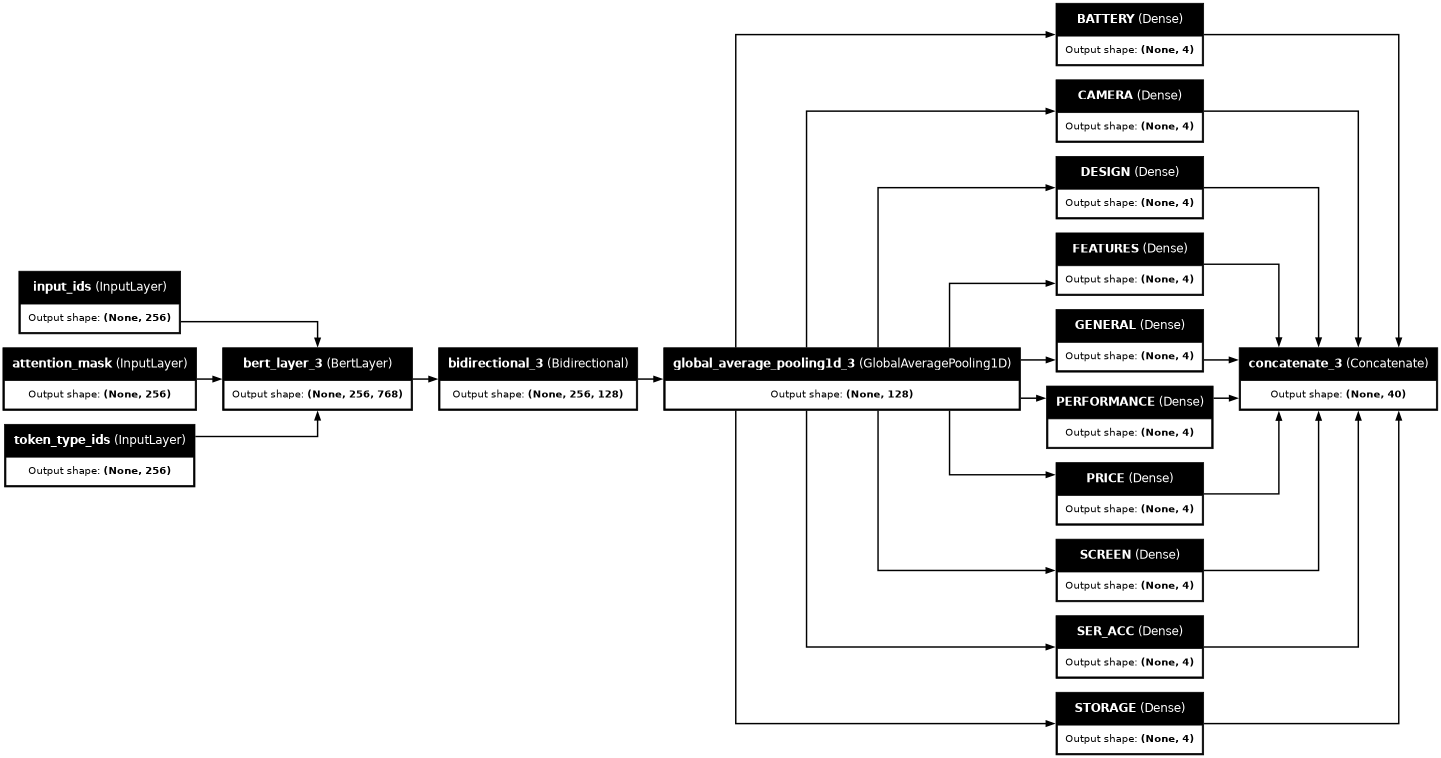

In [74]:
from tensorflow.keras.utils import plot_model
plot_model(reloaded_model, to_file='architecture.png', rankdir='LR', dpi=52, show_shapes=True, show_layer_names=True)

# Prediction

In [75]:
y_test_argmax = np.argmax(y_test, axis=-1)
y_test_argmax

array([[0, 3, 3, ..., 3, 0, 3],
       [0, 0, 0, ..., 3, 0, 3],
       [0, 0, 3, ..., 3, 3, 3],
       ...,
       [1, 3, 3, ..., 3, 3, 3],
       [3, 3, 3, ..., 1, 1, 3],
       [0, 3, 3, ..., 3, 3, 3]])

In [76]:
replacements = {3: None, 0: 'positive', 1: 'negative', 2: 'neutral'}
categories = test_df.columns[1:]

In [77]:
def print_acsa_pred(sentence_pred):
    sentiments = map(lambda x: replacements[x], sentence_pred)
    for category, sentiment in zip(categories, sentiments): 
        if sentiment: print(f'=> {category},{sentiment}')

In [78]:
def predict(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    res = []
    for i in range(len(y_pred)):
        y_pred1 = np.reshape(y_pred[i], (-1, 40))
        res.append(np.argmax(np.reshape(y_pred1, (-1, 4)),axis=-1))
    return res # sentiment values (position that have max value)


In [79]:
def prediction(model, inputs, batch_size=1, verbose=0):
    y_pred = model.predict(inputs, batch_size=batch_size, verbose=verbose)
    y_pred1 = np.reshape(y_pred, (-1, 4))
    print(y_pred1)
    return np.argmax(y_pred1,axis=-1) # sentiment values (position that have max value)

# Report


In [80]:
y_pred = predict(reloaded_model, test_dataset, BATCH_SIZE, verbose=1)

137/137 ━━━━━━━━━━━━━━━━━━━━ 27s 187ms/step


In [81]:
aspect_test = []
aspect_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_test.append(bool(col_test) * categories[index])
        aspect_pred.append(bool(col_pred) * categories[index])
     

In [82]:
from sklearn.metrics import classification_report
aspect_report = classification_report(aspect_test, aspect_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_test, aspect_pred, digits=4, zero_division=1))

              precision    recall  f1-score   support

                 0.6854    0.6699    0.6776      3808
     BATTERY     0.9349    0.8700    0.9013      1600
      CAMERA     0.9322    0.9388    0.9355      1845
      DESIGN     0.9221    0.9572    0.9393      1917
    FEATURES     0.9221    0.9634    0.9423      1966
     GENERAL     0.8157    0.7229    0.7665      1133
 PERFORMANCE     0.8831    0.8428    0.8625      1533
       PRICE     0.9501    0.9864    0.9679      2064
      SCREEN     0.9479    0.9848    0.9660      2034
     SER&ACC     0.9287    0.9542    0.9413      1789
     STORAGE     0.9931    1.0000    0.9966      2171

    accuracy                         0.8889     21860
   macro avg     0.9014    0.8991    0.8997     21860
weighted avg     0.8870    0.8889    0.8876     21860



In [83]:
y_test_flat = y_test_argmax.flatten()
y_pred_flat = [item for sublist in y_pred for item in sublist]
target_names = list(map(str, replacements.values()))

In [84]:
polarity_report = classification_report(y_test_flat, y_pred_flat, digits=4, output_dict=True)
print(classification_report(y_test_flat, y_pred_flat, target_names=target_names, digits=4))

              precision    recall  f1-score   support

        None     0.6854    0.6699    0.6776      3808
    positive     0.6192    0.4443    0.5173      2064
    negative     0.2000    0.0078    0.0150       386
     neutral     0.8707    0.9288    0.8988     15602

    accuracy                         0.8217     21860
   macro avg     0.5938    0.5127    0.5272     21860
weighted avg     0.8029    0.8217    0.8087     21860



In [85]:
aspect_polarity_test = []
aspect_polarity_pred = []

for row_test, row_pred in zip(y_test_argmax, y_pred):
    for index, (col_test, col_pred) in enumerate(zip(row_test, row_pred)):
        aspect_polarity_test.append(f'{categories[index]},{replacements[col_test]}')
        aspect_polarity_pred.append(f'{categories[index]},{replacements[col_pred]}')

In [86]:
aspect_polarity_report = classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1, output_dict=True)
print(classification_report(aspect_polarity_test, aspect_polarity_pred, digits=4, zero_division=1))

                      precision    recall  f1-score   support

        BATTERY,None     0.9017    0.9264    0.9139      1168
    BATTERY,negative     0.6920    0.5450    0.6098       367
     BATTERY,neutral     1.0000    0.0000    0.0000        65
    BATTERY,positive     0.7016    0.8345    0.7623       586
         CAMERA,None     0.8714    0.9499    0.9090      1598
     CAMERA,negative     0.5963    0.3736    0.4594       174
      CAMERA,neutral     0.2857    0.0274    0.0500        73
     CAMERA,positive     0.6555    0.6305    0.6428       341
         DESIGN,None     0.8849    0.9602    0.9210      1810
     DESIGN,negative     0.5000    0.1398    0.2185        93
      DESIGN,neutral     1.0000    0.0000    0.0000        14
     DESIGN,positive     0.5816    0.4238    0.4903       269
       FEATURES,None     0.7922    0.9032    0.8440      1456
   FEATURES,negative     0.6624    0.5449    0.5979       479
    FEATURES,neutral     1.0000    0.0000    0.0000        31
   FEAT

In [87]:
aspect_dict = aspect_report['macro avg']
aspect_dict['accuracy'] = aspect_report['accuracy']

polarity_dict  = polarity_report['macro avg']
polarity_dict['accuracy'] = polarity_report['accuracy']

aspect_polarity_dict = aspect_polarity_report['macro avg']
aspect_polarity_dict['accuracy'] = aspect_polarity_report['accuracy']

In [88]:
df_report = pd.DataFrame.from_dict([aspect_dict, polarity_dict, aspect_polarity_dict])
df_report.index = ['Aspect Detection', 'Polarity Detection', 'Aspect + Polarity']
df_report.drop('support', axis=1)

,precision,recall,f1-score,accuracy
Aspect Detection,0.901397,0.899115,0.899693,0.888930
Polarity Detection,0.593827,0.512688,0.527175,0.821683
Aspect + Polarity,0.681304,0.418201,0.430129,0.821683


In [89]:
example_input = text_preprocess(input('Enter your sentence: '))
tokenized_input = tokenizer(example_input, padding='max_length', truncation=True)
features = {x: [[tokenized_input[x]]] for x in tokenizer.model_input_names}
pred = prediction(reloaded_model, tf.data.Dataset.from_tensor_slices(features))
print_acsa_pred(pred)

Enter your sentence:  điện thoại hơi lag


[[4.89410497e-02 1.17553435e-01 5.02101006e-03 8.28484535e-01]
 [3.05238343e-03 6.40728092e-03 3.48458020e-03 9.87055779e-01]
 [3.80069949e-02 4.05342393e-02 1.29827252e-02 9.08476055e-01]
 [6.80093840e-02 4.77865905e-01 2.29582861e-02 4.31166440e-01]
 [7.96851516e-01 5.66676399e-03 5.15888222e-02 1.45892933e-01]
 [8.84219036e-02 3.54486823e-01 1.42526980e-02 5.42838573e-01]
 [7.22440425e-04 1.41055987e-03 3.84781417e-03 9.94019151e-01]
 [6.12225209e-04 1.39853708e-03 3.97851167e-04 9.97591496e-01]
 [1.01759192e-02 1.34246582e-02 7.01070158e-03 9.69388723e-01]
 [1.63038389e-03 1.72616960e-03 3.34664161e-04 9.96308744e-01]]
=> FEATURES,negative
=> GENERAL,positive
